In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.framework import ops
from keras.models import Model
import keras.backend as K
from keras.layers import Layer
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2
from keras.datasets import cifar10
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from scipy import stats

Using TensorFlow backend.


Define GradCam 

In [0]:
def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = sys.argv[1]
    img = image.load_img(img_path, target_size=(32, 32))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):
        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]
        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu
        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def target_category_loss_output_shape(input_shape):
    return input_shape

def target_category_loss(x, category_index, nb_classes):
        return tf.multiply(x, K.one_hot([category_index], nb_classes))
    
def grad_cam(input_model, image, category_index, layer_name, sparse=False, intialize_model=True):
    nb_classes = 10
    one_hot = K.one_hot([category_index], nb_classes)
    if intialize_model:
        input_model.pop()
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                       output_shape = target_category_loss_output_shape))
    loss = K.sum(input_model.layers[-1].output)
    conv_output =  [l for l in input_model.layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0]) 
    if sparse:
        sparse_name = "sparse_"+layer_name[-1]
        sparse_output = [l for l in input_model.layers if l.name == sparse_name][0].output
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
    
    gradient_function = K.function([input_model.layers[0].input], [conv_output, grads, sparse_output])
    output, grads_val, sparse_output = gradient_function([image])
    
    if sparse:
        output = sparse_output
  
    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    sparse_output = sparse_output[0, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    if sparse:
        output = sparse_output
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (112, 112))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

def intialize_model(input_model):
        input_model.pop()
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                       output_shape = target_category_loss_output_shape)) 
        return input_model

def faster_grad_cam(input_model, image, category_index, changeLastLayer, sparse=False):
    nb_classes = 10
    if changeLastLayer:
        input_model.pop()
        one_hot = K.one_hot([category_index], nb_classes)
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                          output_shape = target_category_loss_output_shape))
    loss = K.sum(input_model.layers[-1].output)
    conv_outputs =  [l for l in input_model.layers if "conv" in l.name]
    conv_1 = conv_outputs[0].output
    conv_2 = conv_outputs[1].output
    conv_3 = conv_outputs[2].output
    conv_4 = conv_outputs[3].output
    grad_1 = normalize(K.gradients(loss, conv_1)[0]) 
    grad_2 = normalize(K.gradients(loss, conv_2)[0]) 
    grad_3 = normalize(K.gradients(loss, conv_3)[0]) 
    grad_4 = normalize(K.gradients(loss, conv_4)[0]) 
    if sparse:
        sparse_outputs = [l for l in input_model.layers if "sparse" in l.name]
        sparse_1 = sparse_outputs[0].output
        sparse_2 = sparse_outputs[1].output
        sparse_3 = sparse_outputs[2].output
        sparse_4 = sparse_outputs[3].output
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
    
    gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                          grad_1, grad_2, grad_3, grad_4,
                                                                                                          sparse_1, sparse_2, sparse_3, sparse_4])
    outputs  = gradient_function([image])
    image_num = image.shape[0]
    conv_outputs = outputs[0:4]
    grad_outputs = outputs[4:8]
    sparse_outputs = outputs[8:12]

    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1

    kl_scores = np.ones((image_num))
    combined = np.zeros((4, 112, 112))

    for i in range(4):
        output, grads_val = conv_outputs[i], grad_outputs[i]
        weights = np.mean(grads_val, axis = (1, 2))
        if sparse:
            sparse_output = sparse_outputs[i]
            output = sparse_output
        cam = np.ones(output.shape[1:3], dtype = np.float32)
        for k, w in enumerate(weights[0]):
            try:
                cam += w * output[0, :, :, k]
            except:
                print("cam shape", cam.shape)
                print("output shape", output.shape)
                print("w", w.shape)
                raise  ValueError(k)
        cam = cv2.resize(cam, (112, 112))
        cam = np.maximum(cam, 0)
        heatmap = cam / np.max(cam)
        combined[i, :, :] = heatmap
    return combined

In [0]:
def batch_grad_cam(input_model, image, category_index, changeLastLayer, sparse=False):
    nb_classes = 10
    if changeLastLayer:
        input_model.pop()
        one_hot = K.one_hot([category_index], nb_classes)
        input_model.add(Lambda(lambda x: tf.math.multiply(x, one_hot),
                                          output_shape = target_category_loss_output_shape))
    loss = K.sum(input_model.layers[-1].output)
    conv_outputs =  [l for l in input_model.layers if "conv" in l.name]
    conv_1 = conv_outputs[0].output
    conv_2 = conv_outputs[1].output
    conv_3 = conv_outputs[2].output
    conv_4 = conv_outputs[3].output
    grad_1 = normalize(K.gradients(loss, conv_1)[0]) 
    grad_2 = normalize(K.gradients(loss, conv_2)[0]) 
    grad_3 = normalize(K.gradients(loss, conv_3)[0]) 
    grad_4 = normalize(K.gradients(loss, conv_4)[0]) 
    if sparse:
        sparse_outputs = [l for l in input_model.layers if "sparse" in l.name]
        sparse_1 = sparse_outputs[0].output
        sparse_2 = sparse_outputs[1].output
        sparse_3 = sparse_outputs[2].output
        sparse_4 = sparse_outputs[3].output
    else:
        sparse_output = input_model.layers[2].output  # to check if KW is implemented correctly 
    
    gradient_function = K.function([input_model.layers[0].input], [conv_1, conv_2, conv_3, conv_4,
                                                                                                          grad_1, grad_2, grad_3, grad_4,
                                                                                                          sparse_1, sparse_2, sparse_3, sparse_4])
    outputs  = gradient_function([image])
    image_num = image.shape[0]
    conv_outputs = outputs[0:4]
    grad_outputs = outputs[4:8]
    sparse_outputs = outputs[8:12]

    one_hot_num = np.zeros((nb_classes))
    one_hot_num[category_index] = 1

    kl_scores = np.ones((image_num))
    combined = np.zeros((image_num, 4, 112, 112))

    # for i in range(2, 4):
    for i in range(4):
        output, grads_val = conv_outputs[i], grad_outputs[i]
        weights = np.mean(grads_val, axis = (1, 2))

        if sparse:
            sparse_output = sparse_outputs[i]
            output = sparse_output

        for j in range(image_num):
          cam = np.ones(output.shape[1:3], dtype = np.float32)
          for k, w in enumerate(weights[j]):
              try:
                  cam += w * output[j, :, :, k]
              except:
                  print("cam shape", cam.shape)
                  print("output shape", output.shape)
                  print("w", w.shape)
                  raise  ValueError(k)
          cam = cv2.resize(cam, (112, 112))
          cam = np.maximum(cam, 0)
          heatmap = cam / np.max(cam)
          combined[j, i, :, :] = heatmap
    return combined

Define K-winners layer

In [0]:
class KW(Layer):
    def __init__(self,  k, beta, filter_num, **kwargs):
        self.k = k
        self.initialize_duty = True
        self.beta = beta
        self.filter_num = filter_num
        super(KW, self).__init__(**kwargs)
    
    def set_duty(self, x):
        self.duty = K.ones((K.shape(x)[0], K.shape(x)[-1]))
        self.initialize_duty = False
    
    def call(self, x):
        if self.initialize_duty:
            self.set_duty(x)
        global_average = K.mean(x, axis=(1, 2)) # (p, c)
        x_sort_arg = self.top_k(global_average, k=self.k) # (?, k)
        boosted_x = self.duty_cycle(tf.cast(x_sort_arg, tf.int64), tf.shape(global_average, out_type=tf.int64)) # 
        boosted_x_arg = self.top_k(boosted_x, k=self.k) # (p, c)
        spx = self.sparse_mtx(x, tf.cast(boosted_x_arg, tf.int64),  tf.shape(global_average, out_type=tf.int64))
        spx = tf.cast(spx, tf.float32)
        spx = tf.expand_dims(spx, axis=1)
        spx = tf.expand_dims(spx, axis=2)
        spx = tf.broadcast_to(spx, tf.shape(x))
        return tf.math.multiply(x, spx)
    
    def top_k(self, x, k):
        return tf.nn.top_k(x, k=k, sorted=True).indices

    def duty_cycle(self, x_sort_arg, x_shape):
        alpha = self.k / self.filter_num
        arg_shape = tf.shape(x_sort_arg)
        R, C = tf.meshgrid(tf.range(arg_shape[0]), tf.range(arg_shape[1]), indexing='ij')
        R = tf.cast(R, tf.int64)
        indices = tf.stack([x_sort_arg, R], axis=-1) 
        indices = tf.reshape(indices, [-1, 2])
        indices = indices[:, ::-1]
        sparse_mtx = tf.SparseTensor(indices=indices, values =tf.ones((x_shape[0]*self.k)),
                                                              dense_shape=x_shape)
        sparse_mtx = tf.sparse.to_dense(sparse_mtx, validate_indices=False)
        duty = tf.cast(sparse_mtx, tf.float32)
        duty = tf.math.add(tf.scalar_mul((1-alpha), self.duty), tf.scalar_mul(alpha, duty))
        return self.boost(duty, alpha) 
    
    def boost(self, duty, alpha):
        alpha_tensor = tf.scalar_mul(alpha, K.ones(K.shape(duty)))
        a = tf.math.subtract(alpha_tensor, duty)
        return K.exp(tf.scalar_mul(self.beta, a))

    def sparse_mtx(self, x, x_sort_arg, x_shape):
        arg_shape = tf.shape(x_sort_arg)
        R, C = tf.meshgrid(tf.range(arg_shape[0]), tf.range(arg_shape[1]), indexing='ij')
        R = tf.cast(R, tf.int64)
        indices = tf.stack([x_sort_arg, R], axis=-1) 
        indices = tf.reshape(indices, [-1, 2])
        indices = indices[:, ::-1]
        
        sparse_mtx = tf.SparseTensor(indices=indices, values =tf.ones((x_shape[0]*self.k)),
                                                              dense_shape=x_shape)
        sparse_mtx = tf.sparse.to_dense(sparse_mtx, validate_indices=False)
        return sparse_mtx
        
    def compute_output_shape(self, input_shape):
        return input_shape
        

Define model

In [0]:
ratio = [0.4, 0.4, 0.7, 0.85]  

In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(112, 112, 1), activation=None, name='conv_1'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(KW(round(32*ratio[0]), 1.5, 32, name="sparse_1"))

model.add(Conv2D(32, kernel_size=3, padding='same', activation=None, name='conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(KW(round(32*ratio[1]), 1.5, 32, name="sparse_2"))

model.add(Conv2D(64, kernel_size=3, activation='relu', name='conv_3'))
model.add(KW(round(64*ratio[2]), 1.5, 64, name="sparse_3"))

model.add(Conv2D(64, kernel_size=3, activation=None, name='conv_4'))
model.add(KW(round(64*ratio[3]) , 1.5, 64, name="sparse_4"))

model.add(Flatten())
model.add(Dense(10, name='dense_1'))
model.add(Activation("softmax", name="softmax"))

In [176]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 112, 112, 32)      320       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
sparse_1 (KW)                (None, 56, 56, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
sparse_2 (KW)                (None, 28, 28, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 26, 26, 64)      

In [0]:
model.load_weights("/content/drive/My Drive/marc_thesis_store/sparse_model.h5")

Load test data

In [178]:
testfile = np.load("/content/drive/My Drive/marc_thesis_store/test_dataset.npz")
x_test = testfile["arr_0"]
print(x_test.shape)
y_test = testfile["arr_1"]
print(y_test.shape)

(10000, 112, 112, 1)
(10000, 10)


Prepare test dataset

In [0]:
preprocessed_x_t = np.ones((len(x_test), 1, 112, 112, 1))
preprocessed_y_t = np.ones((len(x_test)))
preprocessed_y_t = preprocessed_y_t.astype(np.int64)
for i, img in enumerate(x_test):
  preprocessed_y_t[i] = np.argmax(y_test[i])
preprocessed_x_t = x_test
preprocessed_y_t[0].dtype
sorted_arg = preprocessed_y_t.argsort()
sorted_x = preprocessed_x_t[sorted_arg]
sorted_y = preprocessed_y_t[sorted_arg]

border = []
for i in range(10):
  border.append(np.where(sorted_y==i)[0][0])
border.append(len(sorted_y))

Check the test data and the loaded model

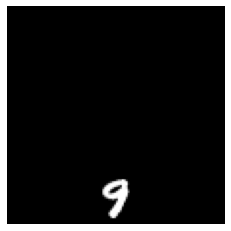

x.shape (1, 112, 112, 1)
predicted_class 3
correct_class 9


In [180]:
p = 8991
x = sorted_x[p]
x_org = x.copy()
plt.imshow(x.reshape(112, 112), cmap="gray")
plt.axis("off")
plt.show()
x = np.expand_dims(x, axis=0)
print("x.shape", x.shape)
preprocessed_input = x
predictions = model.predict(preprocessed_input)
predicted_class = np.argmax(predictions)
print("predicted_class", predicted_class)
print("correct_class",  sorted_y[p])


Visualize the neural activity heatmap and construct the priority map

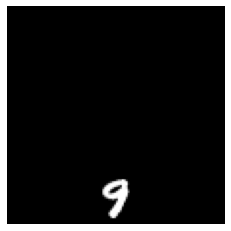

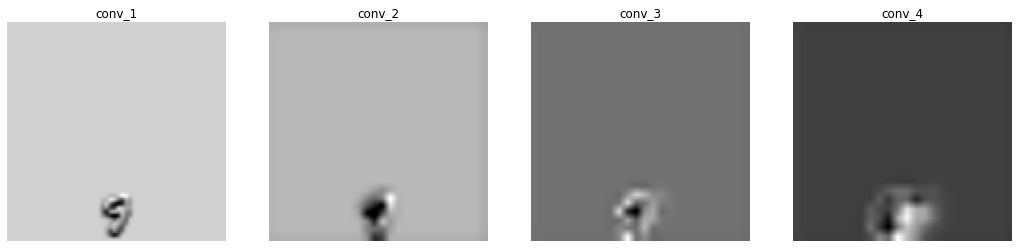

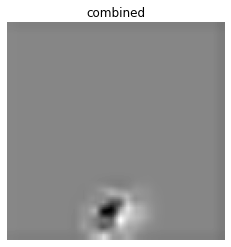

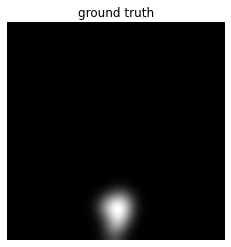

KL divergenvce
3.1637603162096655


In [181]:
plt.imshow(x_org.reshape(112, 112), cmap="gray")
plt.axis("off")
plt.show()
f, a = plt.subplots(1, 4, figsize=(18, 36))
for i in range(1, 5):
    layer_name = "conv_"+str(i)
    cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, layer_name, sparse=True)
    if i ==1:
        combined = np.zeros((heatmap.shape))
    else:
        combined += heatmap
    a[i-1].imshow(heatmap, cmap="gray")
    a[i-1].title.set_text(layer_name)
    a[i-1].axis('off')
plt.show()

combined /= np.sum(combined)
plt.imshow(combined, cmap="gray")
plt.title("combined")
plt.axis("off")
plt.show()

x_comb_gt = scipy.ndimage.gaussian_filter(x_org.reshape(112, 112), 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
plt.imshow(x_comb_gt, cmap="gray")
plt.title("ground truth")
plt.axis("off")
plt.show()

print("KL divergenvce")
print(stats.entropy(x_comb_gt.flatten(), combined.flatten()))

Evaluate the model on the whole test data

In [182]:
kl = np.zeros(len(x_test))
show_img = False
batch_size = 50
yb4 = 0
changeLastLayer = True
results = {}
for i in tqdm(range(10)):
    preprocessed_input = sorted_x[border[i]:border[i+1]]
    y = i
    print("y", y)
    yb4 = y
    combined = batch_grad_cam(model, preprocessed_input, y,  changeLastLayer, sparse=True)
    results[i] = combined
    if show_img:
        plt.imshow(combined[0][0], cmap='gray')
        plt.show()
        plt.imshow(combined[1][0], cmap='gray')
        plt.show()
        plt.imshow(combined[2][0], cmap='gray')
        plt.show()
        plt.imshow(combined[3][0], cmap='gray')
        plt.show()
    img2test = np.sum(combined, axis=0)
    if show_img:
        print("img2test shape", img2test.shape)
        plt.imshow(img2test[0], cmap='gray')
        plt.show()


  0%|          | 0/10 [00:00<?, ?it/s]

y 0


 10%|█         | 1/10 [00:07<01:11,  7.92s/it]

y 1


 20%|██        | 2/10 [00:16<01:05,  8.18s/it]

y 2


 30%|███       | 3/10 [00:25<00:57,  8.23s/it]

y 3


 40%|████      | 4/10 [00:33<00:49,  8.19s/it]

y 4


 50%|█████     | 5/10 [00:41<00:40,  8.15s/it]

y 5


 60%|██████    | 6/10 [00:48<00:31,  7.99s/it]

y 6


 70%|███████   | 7/10 [00:56<00:24,  8.03s/it]

y 7


 80%|████████  | 8/10 [01:05<00:16,  8.12s/it]

y 8


 90%|█████████ | 9/10 [01:13<00:08,  8.08s/it]

y 9


100%|██████████| 10/10 [01:21<00:00,  8.16s/it]


create ground truths

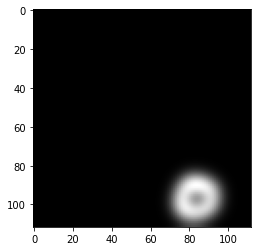

In [183]:
sorted_x_gt = np.ones((sorted_x.shape))
for i, img in enumerate(sorted_x):
  x_comb_gt = scipy.ndimage.gaussian_filter(img.reshape(112, 112), 4, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0) 
  x_comb_gt /= np.sum(x_comb_gt)
  sorted_x_gt[i] = np.expand_dims(x_comb_gt, axis=-1)
plt.imshow(sorted_x_gt[0].reshape(112, 112), cmap='gray')
plt.show()

In [184]:
kls = np.zeros((len(sorted_x_gt)))
for i in range(0, 10):
  gts = sorted_x_gt[border[i]:border[i+1]] 
  pmaps = results[i]
  assert len(gts) == len(pmaps)
  temp = []
  for j in range(len(gts)):
    gt = gts[j].squeeze()
    pmap = np.sum(pmaps[j][1:], axis=0)
    pmap /= np.sum(pmap)
    kl = stats.entropy(gt.flatten(), pmap.flatten())
    temp.append(kl)
    kls[border[i]+j] = kl
  print(i, " class mean: kl", np.mean(temp))
print("KL divergenvce")
print(kls.mean())

0  class mean: kl 2.469635162392086
1  class mean: kl 2.4998036790703257
2  class mean: kl 2.7869119284343467
3  class mean: kl 2.828651180747571
4  class mean: kl 2.3617473786150684
5  class mean: kl 2.7418046599076438
6  class mean: kl 2.3794743834070706
7  class mean: kl 2.56144786189584
8  class mean: kl 2.736782172079404
9  class mean: kl 2.780641355234544
KL divergenvce
2.613947394439586
